In [1]:
import uproot
import ROOT as r
import mplhep
import matplotlib.pyplot as plt
import numpy as np
plt.style.use(mplhep.style.CMS)

Welcome to JupyROOT 6.30/03


In [7]:
lumi = 41.37

f = uproot.open('fitDiagnosticsTest.root')

# f.keys()

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


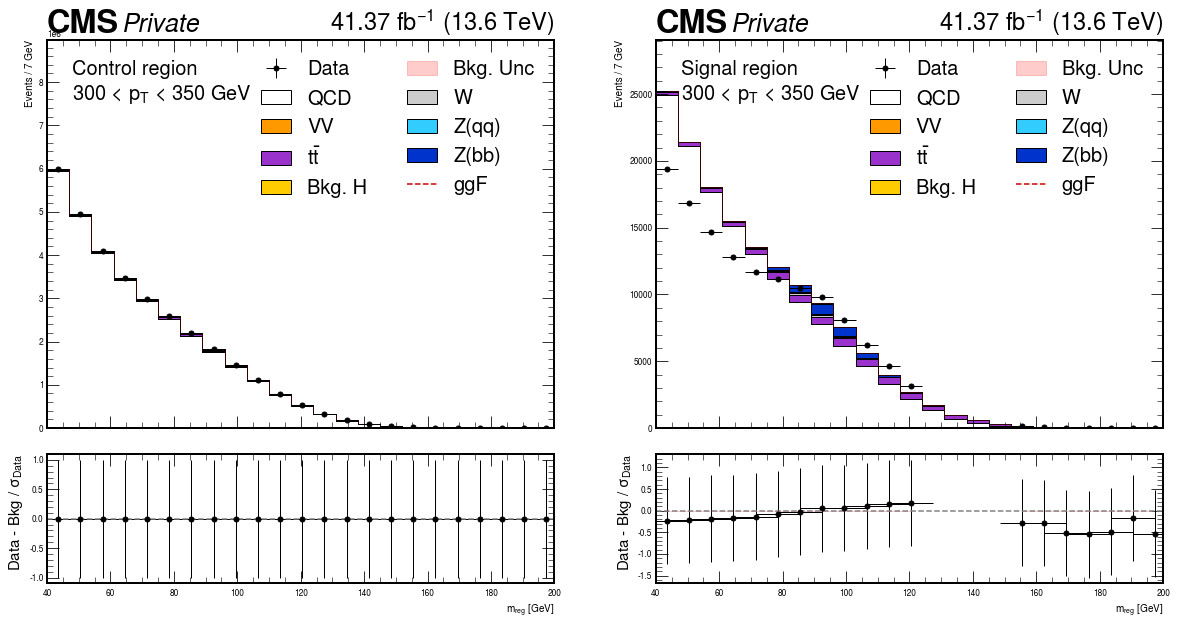

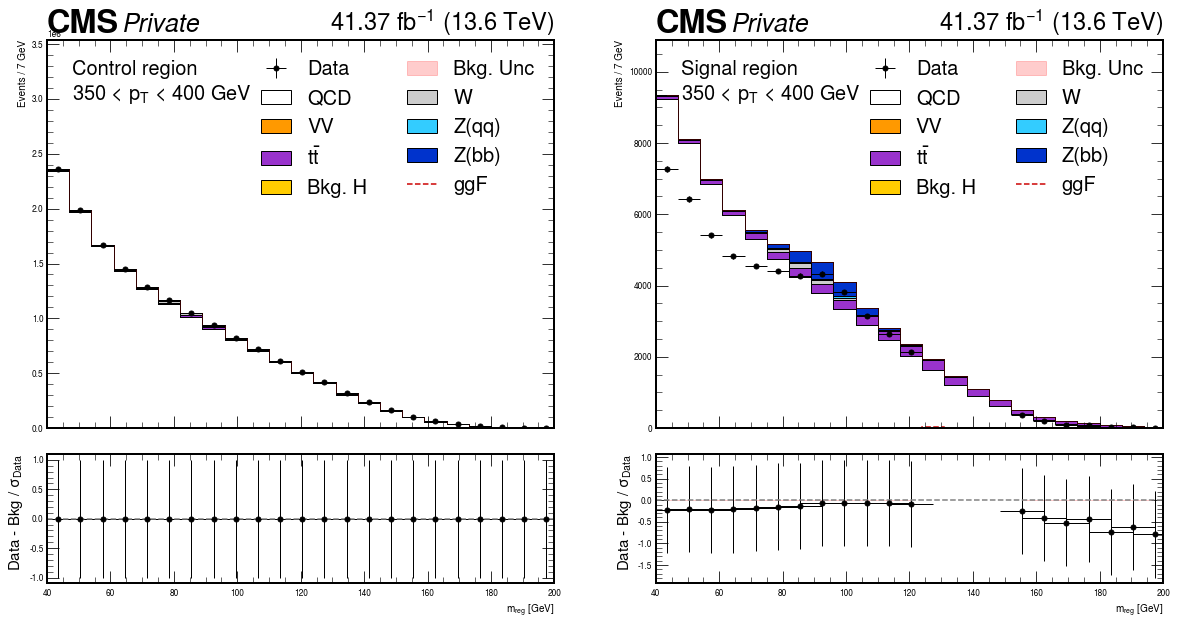

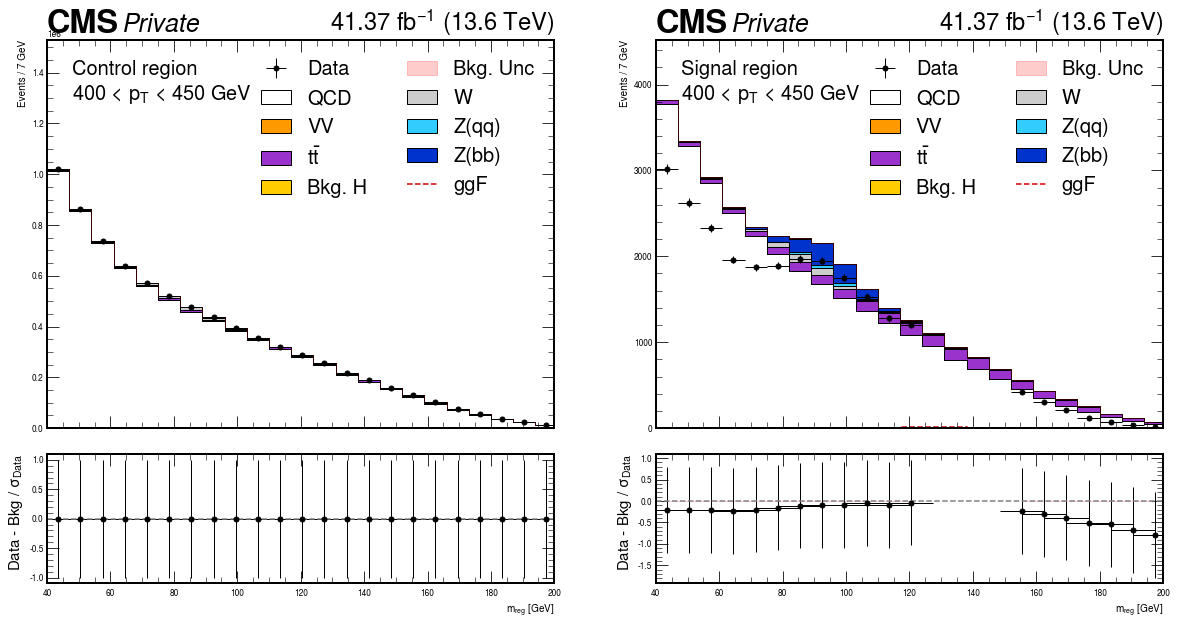

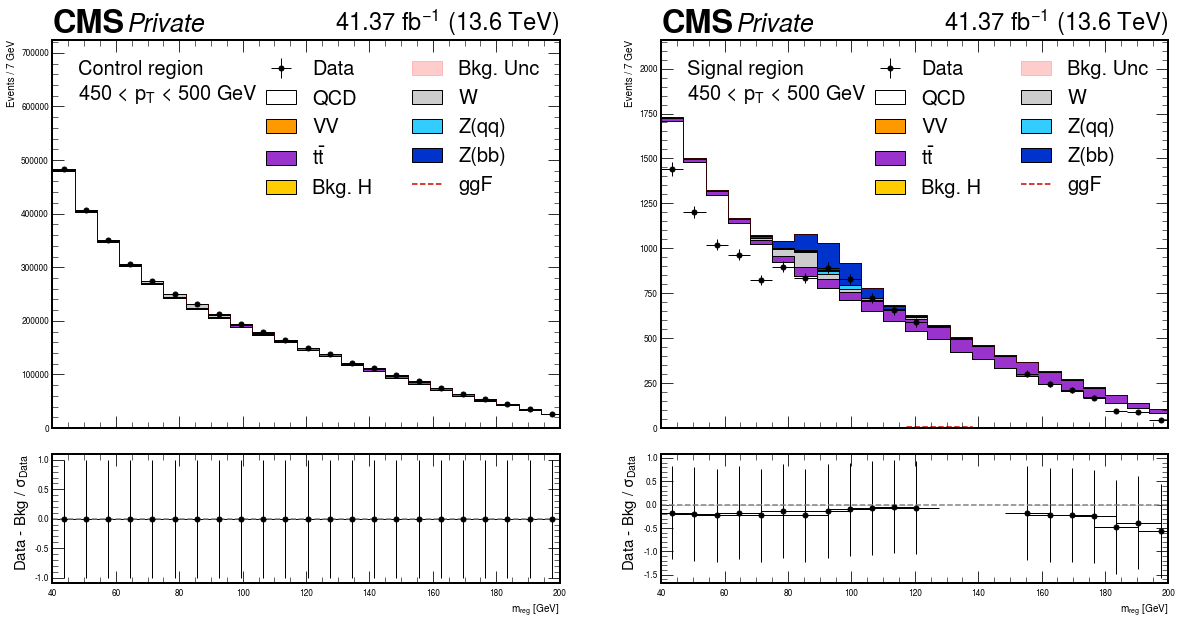

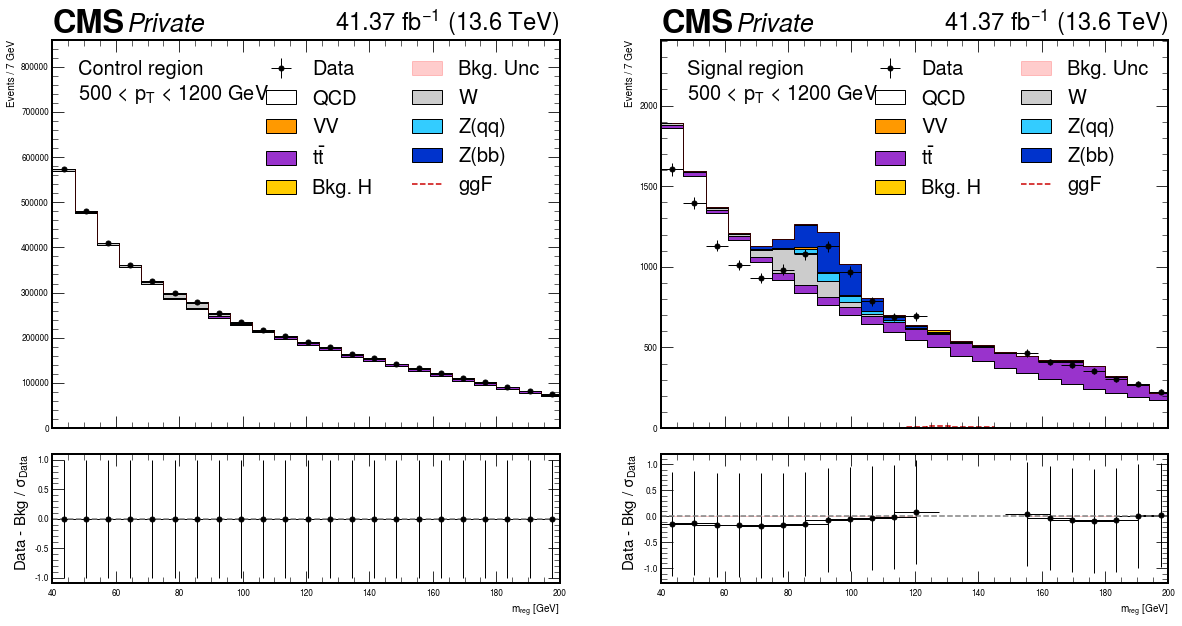

In [3]:
from coffea.hist import clopper_pearson_interval, poisson_interval
plt.style.use(mplhep.style.CMS)

colour = {
    "qcd" : "white",
    "TTbar" : "#9933cc",
    "W" : "#cccccc",
    "ZJetsqq" : "#33ccff",
#     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
    "ZJetsbb" : "#0033cc",
}

label = {
    "qcd" : "QCD",
    "ZJetsbb" : "Z(bb)",
    "ZJetsqq" : "Z(qq)",
    "W" : "W",
    "TTbar" : r"$t\bar{t}$",
    "Single t" : "Single t",
    "VV" : "VV",
}

fit_type = 'fit_s'

pts = [300, 350, 400, 450, 500, 1200] #550, 600, 675, 800, 1200]

for i, _ in enumerate(pts[:-1]):
    
    fig, ((ax1, ax2), (rax1, rax2)) = plt.subplots(
        2, 2, figsize=(20, 10), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)

    for reg, ax, rax in [('fail', ax1, rax1), ('pass', ax2, rax2)]:
    
        hs = []
        labels = []
        colours = []

        fig.subplots_adjust(hspace=0.1)
        ax.set_ylabel("Events / 7 GeV")
        rax.set_ylabel(r"Data - Bkg / $\sigma_{Data}$", fontsize=15)
        rax.set_xlabel(r"m$_{reg}$ [GeV]")
        ax.set_xlabel(" ")

        for process in colour.keys():

            h = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/{process}'].to_hist() * 7

            hs.append(h)
            labels.append(label[process])
            colours.append(colour[process])

        higgs_h = None

        for process in ['VBF', 'ZH', 'WH', 'ttH']:

            h = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/{process}'].to_hist() * 7

            if not higgs_h:
                higgs_h = h
            else:
                higgs_h += h

        hs.append(higgs_h)
        labels.append("Bkg. H")
        colours.append("#ffcc00")

        mplhep.histplot(
            hs,
            ax=ax,
            label=labels,
            stack=True,
            color=colours,
            histtype="fill",
            edgecolor="black",
            linewidth=1,
            flow="none",
        )

        h_ggf = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/ggF'].to_hist() * 7

        mplhep.histplot(
            h_ggf, 
            ax=ax,
            yerr=False,
            color="#cc0000",
            label=f"ggF",
            linestyle="dashed",
            flow="none",
        )

        data = uproot.open("signalregion.root")
        h_data = data[f'ggf_{reg}_pt{i+1}_data_nominal'].to_hist()
        if reg == "pass":
            for i_nan in [12, 13, 14, 15]:
                    h_data[i_nan] = [np.nan, np.nan]

        mplhep.histplot(
            h_data, 
            ax=ax, 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data",
            flow="none",
        )

        hs_mc = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/total_background'].to_hist() * 7
        
        hs_mc_x = hs_mc.axes[0].centers
        hs_mc_y = hs_mc.values()
        hs_mc_unc = np.sqrt(hs_mc.variances())
        
        ax.fill_between(hs_mc_x, hs_mc_y - hs_mc_unc, hs_mc_y + hs_mc_unc,
                         step='mid', alpha=0.2, label='Bkg. Unc', color='red')

        centers = h_data.axes[0].centers
        sumw_data, sumw2_data = h_data.values(), h_data.variances()
        sumw_mc, sumw2_mc = hs_mc.values(), hs_mc.variances()
        
        hs_mc_sub = np.sqrt(sumw2_mc) / np.sqrt(sumw2_data)
        rat_sub = (sumw_data - sumw_mc) / np.sqrt(sumw2_data)
        rat_sub_2 = (sumw_data / sumw_mc) - 1
        rat_sub_unc = np.sqrt(sumw2_data) / np.sqrt(sumw2_data)
        ggf_sub = h_ggf.values() / np.sqrt(sumw2_data)

#         rsumw = sumw_num / np.maximum(1, sumw_denom)
#         rsumw_unc = poisson_interval(
#             rsumw,
#             sumw2_num / sumw_denom**2
#         )

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

#         rax.errorbar(
#             centers,
#             rsumw,
#             xerr=centers[1]-centers[0],
#             yerr=rsumw_unc,
#             **data_err_opts,
#         )

        rax.fill_between(centers, np.zeros(len(hs_mc_sub)) - hs_mc_sub, np.zeros(len(hs_mc_sub)) + hs_mc_sub,
                         step='mid', alpha=0.2, label='Bkg. Unc', color='red')

        rax.errorbar(
            centers,
            rat_sub_2,
            xerr=centers[1]-centers[0],
            yerr=rat_sub_unc,
            **data_err_opts,
        )

        rax.axhline(0, color='gray',ls='--')

        mplhep.cms.label(
            ax=ax, 
            data=True, 
            fontsize=25,
            label="Private",
#             year=2022,
            lumi=f"{lumi:.2f}",
            com=13.6,
        )

        handles, labels = ax.get_legend_handles_labels()
        order = [9, 0, 4, 1, 6, 8, 2, 3, 5, 7]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, ncols=2)

        ax.set_ylim(0, max(h_data.values()) * 1.5)
        
        reg_text = "Signal" if reg == "pass" else "Control"
        plt.text(0.05, 0.83, f"{reg_text} region\n{pts[i]:.0f} < " + r"$p_T$" + f" < {pts[i+1]} GeV",
                    fontsize=20,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )
        
        ax.set_xlim(40, 200)

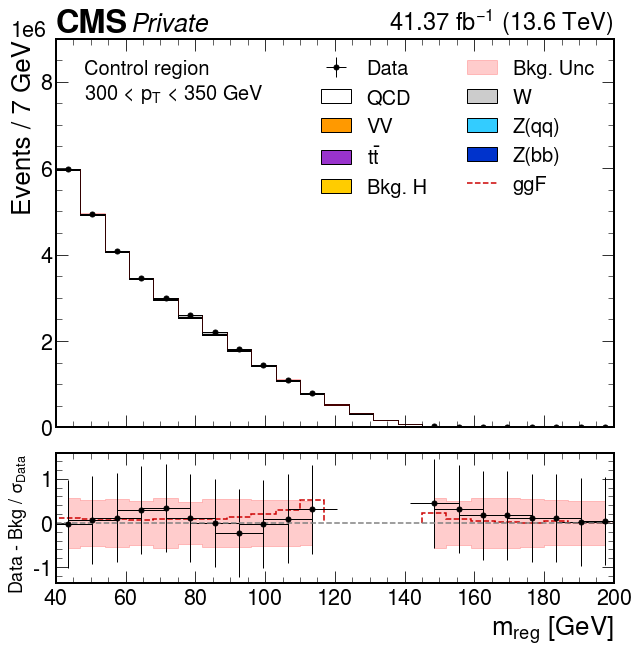

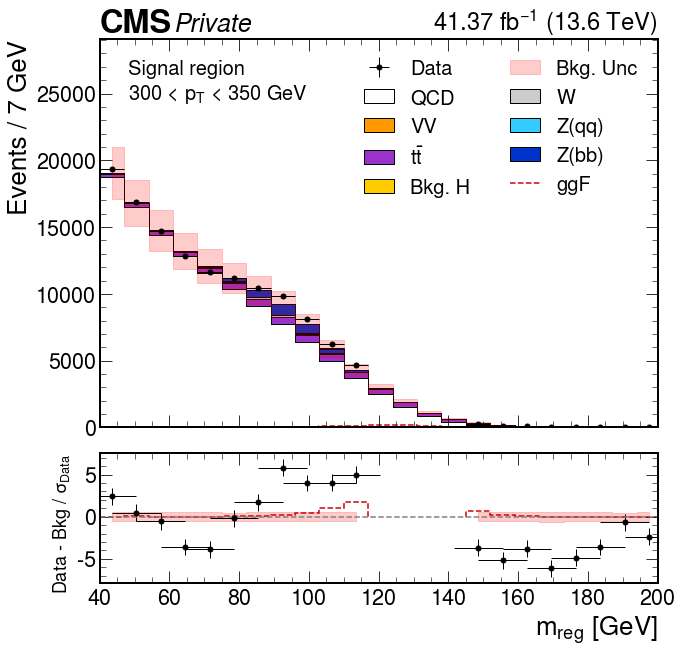

In [13]:
from coffea.hist import clopper_pearson_interval, poisson_interval
plt.style.use(mplhep.style.CMS)

colour = {
    "qcd" : "white",
    "TTbar" : "#9933cc",
    "W" : "#cccccc",
    "ZJetsqq" : "#33ccff",
#     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
    "ZJetsbb" : "#0033cc",
}

label = {
    "qcd" : "QCD",
    "ZJetsbb" : "Z(bb)",
    "ZJetsqq" : "Z(qq)",
    "W" : "W",
    "TTbar" : r"$t\bar{t}$",
    "Single t" : "Single t",
    "VV" : "VV",
}

pts = [300, 350]

fit_type = 'fit_s'

for i, _ in enumerate(pts[:-1]):

    for reg in ['fail', 'pass']:
        
        fig, (ax, rax) = plt.subplots(
            2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
        )
        fig.subplots_adjust(hspace=0.1)
    
        hs = []
        labels = []
        colours = []

        fig.subplots_adjust(hspace=0.1)
        ax.set_ylabel("Events / 7 GeV")
        rax.set_ylabel(r"Data - Bkg / $\sigma_{Data}$", fontsize=18)
        rax.set_xlabel(r"m$_{reg}$ [GeV]")
        ax.set_xlabel(" ")

        for process in colour.keys():

            h = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/{process}'].to_hist() * 7

            hs.append(h)
            labels.append(label[process])
            colours.append(colour[process])

        higgs_h = None

        for process in ['VBF', 'ZH', 'WH', 'ttH']:

            h = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/{process}'].to_hist() * 7

            if not higgs_h:
                higgs_h = h
            else:
                higgs_h += h

        hs.append(higgs_h)
        labels.append("Bkg. H")
        colours.append("#ffcc00")

        mplhep.histplot(
            hs,
            ax=ax,
            label=labels,
            stack=True,
            color=colours,
            histtype="fill",
            edgecolor="black",
            linewidth=1,
            flow="none",
        )

        h_ggf = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/ggF'].to_hist() * 7

        mplhep.histplot(
            h_ggf, 
            ax=ax,
            yerr=False,
            color="#cc0000",
            label=f"ggF",
            linestyle="dashed",
            flow="none",
        )

        data = uproot.open("signalregion.root")
        h_data = data[f'ggf_{reg}_pt{i+1}_data_nominal'].to_hist()
        if True:
            for i_nan in [11, 12, 13, 14]:
                    h_data[i_nan] = [np.nan, np.nan]

        mplhep.histplot(
            h_data, 
            ax=ax, 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data",
            flow="none",
        )

        hs_mc = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/total_background'].to_hist() * 7
        
        hs_mc_x = hs_mc.axes[0].centers
        hs_mc_y = hs_mc.values()
        hs_mc_unc = np.sqrt(hs_mc.variances())
        
        if reg == "pass":
            ax.fill_between(hs_mc_x, (hs_mc_y - hs_mc_unc) * 0.9, (hs_mc_y + hs_mc_unc) * 1.1,
                         step='mid', alpha=0.2, label='Bkg. Unc', color='red')
        else:
            ax.fill_between(hs_mc_x, hs_mc_y - hs_mc_unc, hs_mc_y + hs_mc_unc,
                         step='mid', alpha=0.2, label='Bkg. Unc', color='red')

        centers = h_data.axes[0].centers
        sumw_data, sumw2_data = h_data.values(), h_data.variances()
        sumw_mc, sumw2_mc = hs_mc.values(), hs_mc.variances()
        
        hs_mc_sub = np.sqrt(sumw2_mc) / np.sqrt(sumw2_data)
        rat_sub = (sumw_data - sumw_mc) / np.sqrt(sumw2_data)
        rat_sub_2 = (sumw_data / sumw_mc) - 1
        rat_sub_unc = np.sqrt(sumw2_data) / np.sqrt(sumw2_data)
        h_ggf_sub = h_ggf.values() / np.sqrt(sumw2_data)
        edges = h_ggf.axes[0].edges

#         rsumw = sumw_num / np.maximum(1, sumw_denom)
#         rsumw_unc = poisson_interval(
#             rsumw,
#             sumw2_num / sumw_denom**2
#         )

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

#         rax.errorbar(
#             centers,
#             rsumw,
#             xerr=centers[1]-centers[0],
#             yerr=rsumw_unc,
#             **data_err_opts,
#         )

#         if i == 3 and reg == "fail":
#             print(hs_mc_sub)
            
#         hs_mc_sub = [0.56829283, 0.51651296, 0.54519907, 0.50163849, 0.55933648, 0.48491636, 0.53982602, 0.54246389, 0.51910101, 0.52370271, 0.50200542, np.nan, np.nan, np.nan, np.nan, 0.56710975, 0.50378835, 0.55594506, 0.57269052, 0.53976455, 0.50815457, 0.49737066, 0.50564471]

        rax.fill_between(centers, np.zeros(len(hs_mc_sub)) - hs_mc_sub, np.zeros(len(hs_mc_sub)) + hs_mc_sub,
                         step='mid', alpha=0.2, label='Bkg. Unc', color='red')

        rax.errorbar(
            centers,
            rat_sub,
            xerr=centers[1]-centers[0],
            yerr=rat_sub_unc,
            **data_err_opts,
        )

        rax.axhline(0, color='gray',ls='--')
        
        mplhep.histplot(
            h_ggf_sub,
            edges, 
            ax=rax,
            yerr=False,
            color="#cc0000",
            linestyle="dashed",
            flow="none",
        )

        mplhep.cms.label(
            ax=ax, 
            data=True, 
            fontsize=25,
            label="Private",
#             year=2022,
            lumi=f"{lumi:.2f}",
            com=13.6,
        )

        handles, labels = ax.get_legend_handles_labels()
        order = [9, 0, 4, 1, 6, 8, 2, 3, 5, 7]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, ncols=2)

        ax.set_ylim(0, max(h_data.values()) * 1.5)
        
        reg_text = "Signal" if reg == "pass" else "Control"
        plt.text(0.05, 0.83, f"{reg_text} region\n{pts[i]:.0f} < " + r"$p_T$" + f" < {pts[i+1]} GeV",
                    fontsize=20,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )
        
        ax.set_xlim(40, 200)
        t = ax.yaxis.get_offset_text()
        t.set_x(-0.08)
        
        plt.savefig(f"plots/ggF_{reg}_{i}.pdf", bbox_inches='tight', pad_inches=0.1)

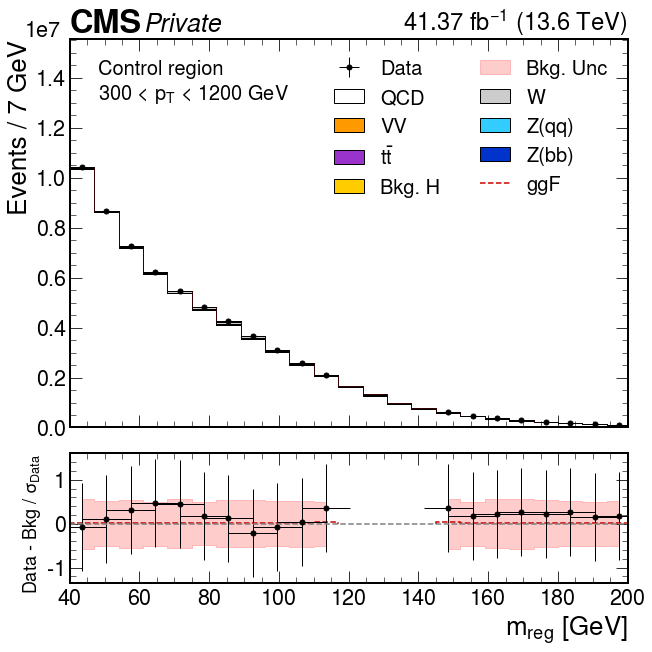

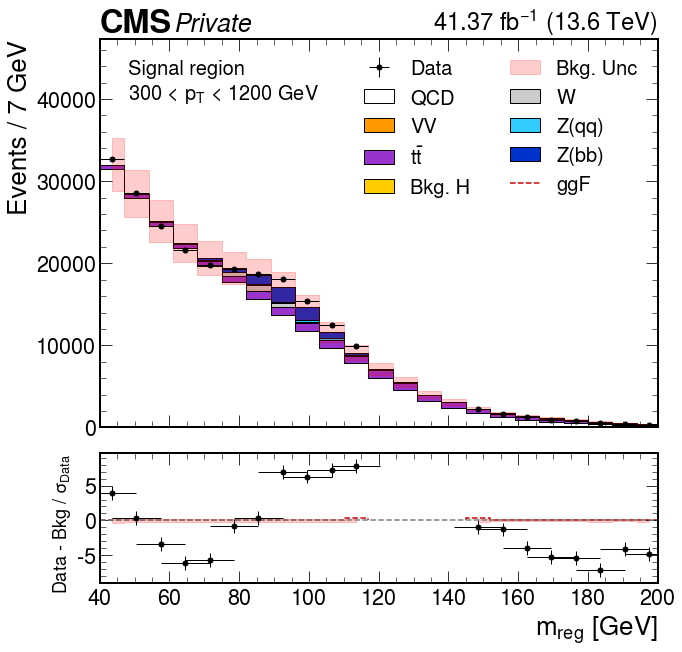

In [15]:
from coffea.hist import clopper_pearson_interval, poisson_interval
plt.style.use(mplhep.style.CMS)

colour = {
    "qcd" : "white",
    "TTbar" : "#9933cc",
    "W" : "#cccccc",
    "ZJetsqq" : "#33ccff",
#     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
    "ZJetsbb" : "#0033cc",
}

label = {
    "qcd" : "QCD",
    "ZJetsbb" : "Z(bb)",
    "ZJetsqq" : "Z(qq)",
    "W" : "W",
    "TTbar" : r"$t\bar{t}$",
    "Single t" : "Single t",
    "VV" : "VV",
}

fit_type = 'fit_s'

pts = [300, 350, 400, 450, 500, 1200] #550, 600, 675, 800, 1200]

for reg in ['fail', 'pass']:
    
    hs = []
    labels = []
    colours = []
    
    hists = {
        "qcd" : None,
        "ZJetsbb" : None,
        "ZJetsqq" : None,
        "W" : None,
        "TTbar" : None,
        "Single t" : None,
        "VV" : None,
        "ggF" : None,
        "data" : None,
        "Bkg. H." : None,
        "MC" : None,
    }

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / 7 GeV")
    rax.set_ylabel(r"Data - Bkg / $\sigma_{Data}$", fontsize=18)
    rax.set_xlabel(r"m$_{reg}$ [GeV]")
    ax.set_xlabel(" ")

    for i, _ in enumerate(pts[:-1]):

        for process in colour.keys():

            h = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/{process}'].to_hist() * 7

            if not hists[process]:
                hists[process] = h
            else:
                hists[process] = hists[process] + h

        higgs_h = None

        for process in ['VBF', 'ZH', 'WH', 'ttH']:

            h = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/{process}'].to_hist() * 7

            if not higgs_h:
                higgs_h = h
            else:
                higgs_h += h

        if not hists["Bkg. H."]:
            hists["Bkg. H."] = h
        else:
            hists["Bkg. H."] = hists["Bkg. H."] + h

        h_ggf = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/ggF'].to_hist() * 7

        if not hists["ggF"]:
            hists["ggF"] = h
        else:
            hists["ggF"] = hists["ggF"] + h
        
        data = uproot.open("signalregion.root")
        h_data = data[f'ggf_{reg}_pt{i+1}_data_nominal'].to_hist()

        if not hists["data"]:
            hists["data"] = h_data
        else:
            hists["data"] = hists["data"] + h_data

        hs_mc = f[f'shapes_{fit_type}/ptbin{i}ggf{reg}2022/total_background'].to_hist() * 7
        
        if not hists["MC"]:
            hists["MC"] = hs_mc
        else:
            hists["MC"] = hists["MC"] + hs_mc
            
    for process in colour.keys():

        hs.append(hists[process])
        labels.append(label[process])
        colours.append(colour[process])
    
    hs.append(higgs_h)
    labels.append("Bkg. H")
    colours.append("#ffcc00")

    mplhep.histplot(
        hs,
        ax=ax,
        label=labels,
        stack=True,
        color=colours,
        histtype="fill",
        edgecolor="black",
        linewidth=1,
        flow="none",
    )
    
    mplhep.histplot(
        hists["ggF"], 
        ax=ax,
        yerr=False,
        color="#cc0000",
        label=f"ggF",
        linestyle="dashed",
        flow="none",
    )

    h_data = hists["data"]
    if True:
        for i_nan in [11, 12, 13, 14]:
                h_data[i_nan] = [np.nan, np.nan]

    mplhep.histplot(
        h_data, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"Data",
        flow="none",
    )
    
    hs_mc = hists["MC"]
            
    hs_mc_x = hs_mc.axes[0].centers
    hs_mc_y = hs_mc.values()
    hs_mc_unc = np.sqrt(hs_mc.variances())

    if reg == "pass":
        ax.fill_between(hs_mc_x, (hs_mc_y - hs_mc_unc) * 0.9, (hs_mc_y + hs_mc_unc) * 1.1,
                     step='mid', alpha=0.2, label='Bkg. Unc', color='red')
    else:
        ax.fill_between(hs_mc_x, hs_mc_y - hs_mc_unc, hs_mc_y + hs_mc_unc,
                     step='mid', alpha=0.2, label='Bkg. Unc', color='red')

    centers = h_data.axes[0].centers
    sumw_data, sumw2_data = h_data.values(), h_data.variances()
    sumw_mc, sumw2_mc = hs_mc.values(), hs_mc.variances()

    hs_mc_sub = (np.sqrt(sumw2_mc) / np.sqrt(sumw2_data)) 
    rat_sub = (sumw_data - sumw_mc) / np.sqrt(sumw2_data)
    rat_sub_2 = (sumw_data / sumw_mc) - 1
    rat_sub_unc = np.sqrt(sumw2_data) / np.sqrt(sumw2_data)
    h_ggf_sub = h_ggf.values() / np.sqrt(sumw2_data)
    edges = h_ggf.axes[0].edges
    
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }
    
    if reg == 'fail':
        hs_mc_sub = [0.56829283, 0.51651296, 0.54519907, 0.50163849, 0.55933648, 0.48491636, 0.53982602, 0.54246389, 0.51910101, 0.52370271, 0.50200542, np.nan, np.nan, np.nan, np.nan, 0.56710975, 0.50378835, 0.55594506, 0.57269052, 0.53976455, 0.50815457, 0.49737066, 0.50564471]

    rax.fill_between(centers, np.zeros(len(hs_mc_sub)) - hs_mc_sub, np.zeros(len(hs_mc_sub)) + hs_mc_sub,
                     step='mid', alpha=0.2, label='Bkg. Unc', color='red')

    rax.errorbar(
        centers,
        rat_sub,
        xerr=centers[1]-centers[0],
        yerr=rat_sub_unc,
        **data_err_opts,
    )

    rax.axhline(0, color='gray',ls='--')
    
    mplhep.histplot(
        h_ggf_sub,
        edges, 
        ax=rax,
        yerr=False,
        color="#cc0000",
        linestyle="dashed",
        flow="none",
    )

    mplhep.cms.label(
        ax=ax, 
        data=True, 
        fontsize=25,
        label="Private",
#             year=2022,
        lumi=f"{lumi:.2f}",
        com=13.6,
    )

    handles, labels = ax.get_legend_handles_labels()
    order = [9, 0, 4, 1, 6, 8, 2, 3, 5, 7]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, ncols=2)

    ax.set_ylim(0, max(hists["qcd"].values()) * 1.5)

    reg_text = "Signal" if reg == "pass" else "Control"
    plt.text(0.05, 0.83, f"{reg_text} region\n300 < " + r"$p_T$" + f" < 1200 GeV",
                fontsize=20,
                horizontalalignment='left',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    ax.set_xlim(40, 200)
    
    t = ax.yaxis.get_offset_text()
    t.set_x(-0.08)
    
    plt.savefig(f"plots/ggF_{reg}.pdf", bbox_inches='tight', pad_inches=0.1)